In [59]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_classif, mutual_info_classif

import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv('mushroom/secondary_data.csv', sep=';')
print(df.shape)
df.head()

(61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [46]:
df.groupby(['class'])['class'].count() / df.shape[0]

class
e    0.445087
p    0.554913
Name: class, dtype: float64

# Convert the Binary features

In [105]:
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].replace('t', 1)
df['does-bruise-or-bleed'] = df['does-bruise-or-bleed'].replace('f', 0)
df['has-ring'] = df['has-ring'].replace('t', 1)
df['has-ring'] = df['has-ring'].replace('f', 0)

In [106]:
print("The data types of the columns are:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.dtypes)

The data types of the columns are:
class                   category
cap-diameter             float64
cap-shape               category
cap-surface             category
cap-color               category
does-bruise-or-bleed    category
gill-attachment         category
gill-spacing            category
gill-color              category
stem-height              float64
stem-width               float64
stem-root               category
stem-surface            category
stem-color              category
veil-type               category
veil-color              category
has-ring                category
ring-type               category
spore-print-color       category
habitat                 category
season                  category
dtype: object


In [135]:
df['season'].unique()

['w', 'u', 'a', 's']
Categories (4, object): ['a', 's', 'u', 'w']

The features are:\
n: nominal, m: metrical
- **cap-diameter (m)**: float number in cm
- **cap-shape (n)**: bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p, others=o
- **cap-surface (n)**: fibrous=i, grooves=g, scaly=y, smooth=s, shiny=h, leathery=l, silky=k, sticky=t, wrinkled=w, fleshy=e
- **cap-color (n)**: brown=n, buff=b, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y, blue=l, orange=o, black=k
- **does-bruise-bleed (n)**: bruises-or-bleeding=t,no=f
- **gill-attachment (n)**: adnate=a, adnexed=x, decurrent=d, free=e, sinuate=s, pores=p, none=f, unknown=?
- **gill-spacing (n)**: close=c, distant=d, none=f
- **gill-color (n)**: see cap-color + none=f
- **stem-height (m)**: float number in cm
- **stem-root (n)**: bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r
- **stem-surface (n)**: see cap-surface + none=f
- **stem-color (n)**: see cap-color + none=f
- **veil-type (n)**: partial=p, universal=u
- **veil-color (n)**: see cap-color + none=f
- **has-ring (n)**: ring=t, none=f
- **ring-type (n)**: cobwebby=c, evanescent=e, flaring=r, grooved=g, large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?
- **spore-print-color (n)**:   see cap color
- **habitat (n)**: grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d
- **season (n)**: spring=s, summer=u, autumn=a, winter=w


In [13]:
# change column type from object to category
for col in ['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color','habitat', 'season']:
       df[col] = df[col].astype('category')

In [14]:
# Check the missing values of data
# columns that have missing value
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
cap-surface          0.231214
gill-attachment      0.161850
gill-spacing         0.410405
stem-root            0.843931
stem-surface         0.624277
veil-type            0.947977
veil-color           0.878613
ring-type            0.040462
spore-print-color    0.895954
dtype: float64


In [15]:
# split the features and target variable
y = df['class']
X = df.drop(columns='class')
print(X.shape, y.shape)

(61069, 20) (61069,)


# EDA

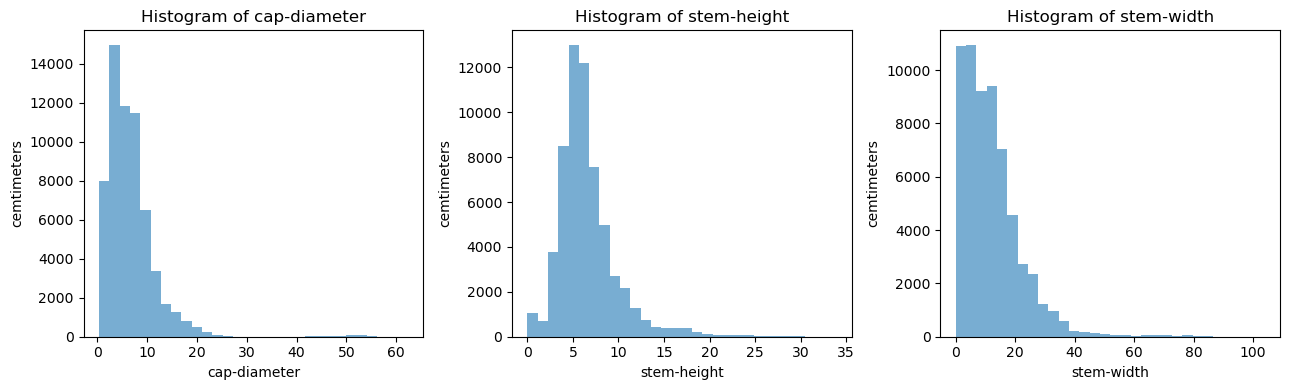

In [95]:
# The histogram of all the features
plt.figure(figsize=(13,4))
i=0
for col in ['cap-diameter', 'stem-height', 'stem-width']:
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=30, alpha=0.6)
    plt.xlabel("{}".format(col), fontsize=10)
    plt.ylabel('cemtimeters')
    plt.title('Histogram of {}'.format(col))
    i += 1
plt.tight_layout()
plt.show()

In [115]:
count_matrix = df.groupby(['cap-color', 'class']).size().unstack()
print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0).sort_values(['e'], ascending=False)
print(count_matrix_norm)

class          e      p
cap-color              
b            974    256
e            880   3155
g           2297   2123
k            501    778
l            452    376
n          12407  11811
o           1071   2585
p            449   1254
r            198   1584
u            611   1098
w           3750   3916
y           3591   4952
class             e         p
cap-color                    
b          0.791870  0.208130
l          0.545894  0.454106
g          0.519683  0.480317
n          0.512305  0.487695
w          0.489173  0.510827
y          0.420344  0.579656
k          0.391712  0.608288
u          0.357519  0.642481
o          0.292943  0.707057
p          0.263652  0.736348
e          0.218092  0.781908
r          0.111111  0.888889


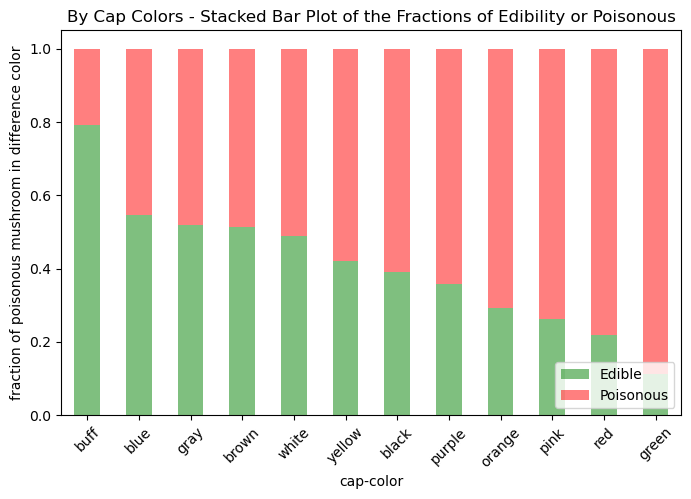

In [117]:
count_matrix = df.groupby(['cap-color', 'class']).size().unstack()

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0).sort_values(['e'], ascending=False)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(8,5), alpha=0.5, color = ['green', 'red'])
plt.ylabel('fraction of poisonous mushroom in difference color')
plt.title('By Cap Colors - Stacked Bar Plot of the Fractions of Edibility or Poisonous')
plt.legend(loc=4, labels=['Edible', 'Poisonous'])
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], 
           ['buff','blue','gray','brown','white','yellow','black','purple','orange','pink','red','green'], rotation=45)
plt.show()

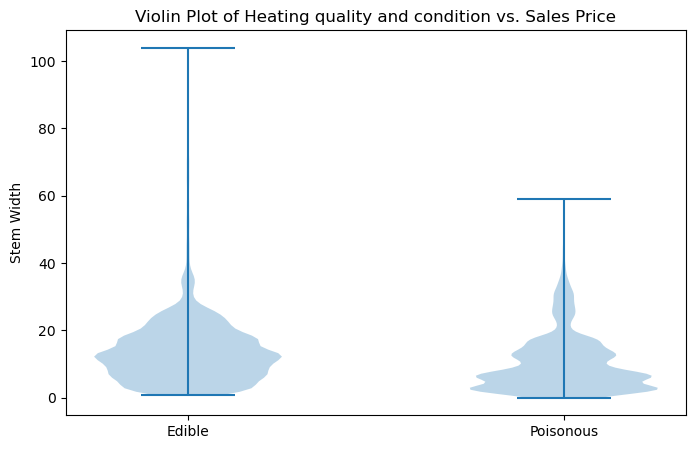

In [19]:
# your code here 
dataset = [df[df['class']=='e']['stem-width'].values,
           df[df['class']=='p']['stem-width'].values]

plt.figure(figsize=(8,5))

plt.violinplot(dataset = dataset)
plt.xticks([1,2],['Edible','Poisonous'])
plt.ylabel('Stem Width')
plt.title('Violin Plot of Heating quality and condition vs. Sales Price')
plt.show()

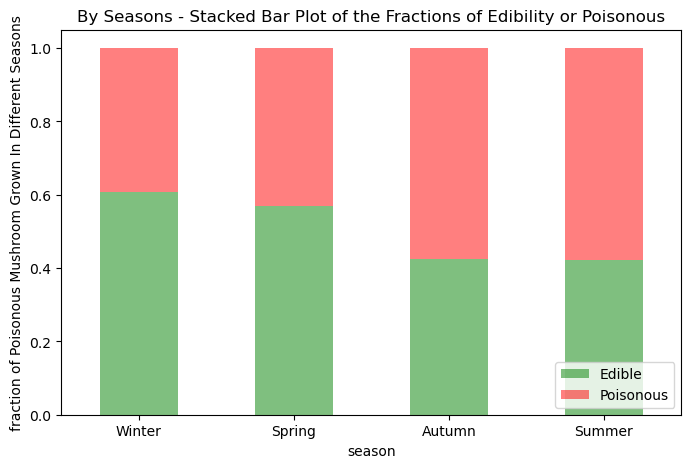

In [113]:
count_matrix = df.groupby(['season', 'class']).size().unstack()

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0).sort_values(['e'], ascending=False)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(8,5), alpha=0.5, color = ['green', 'red'])
plt.ylabel('fraction of Poisonous Mushroom Grown In Different Seasons')
plt.title('By Seasons - Stacked Bar Plot of the Fractions of Edibility or Poisonous')
plt.legend(loc=4, labels=['Edible', 'Poisonous'])
plt.xticks([0,1,2,3], 
           ['Winter', 'Spring', 'Autumn', 'Summer'], rotation=0)
plt.show()

In [140]:
count_matrix = df.groupby(['habitat', 'class']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0).sort_values(['e'], ascending=False)
count_matrix_norm

class,e,p
habitat,,
u,1.000000,0.000000
w,1.000000,0.000000
l,0.611742,0.388258
m,0.488699,0.511301
d,0.456084,0.543916
h,0.347826,0.652174
g,0.313358,0.686642
p,0.000000,1.000000


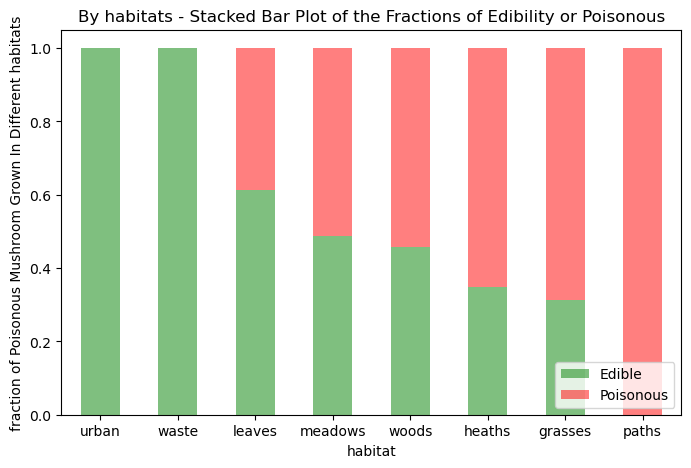

In [142]:
count_matrix = df.groupby(['habitat', 'class']).size().unstack()

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1), axis=0).sort_values(['e'], ascending=False)

count_matrix_norm.plot(kind='bar', stacked=True, figsize=(8,5), alpha=0.5, color = ['green', 'red'])
plt.ylabel('fraction of Poisonous Mushroom Grown In Different habitats')
plt.title('By habitats - Stacked Bar Plot of the Fractions of Edibility or Poisonous')
plt.legend(loc=4, labels=['Edible', 'Poisonous'])
plt.xticks([0,1,2,3,4,5,6,7], 
           ['urban', 'waste', 'leaves', 'meadows', 'woods', 'heaths', 'grasses', 'paths'], rotation=0)
plt.show()

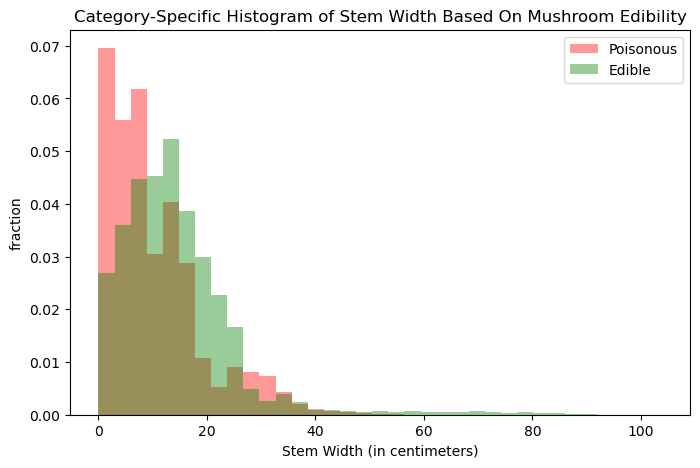

In [134]:
categories = df['class'].unique()
bin_range = (df['stem-width'].min(),df['stem-width'].max())
dict_color = dict(
    {'e': 'green',
    'p': 'red'}
)
plt.figure(figsize=(8,5))

for c in categories:
    plt.hist(df[df['class']==c]['stem-width'],alpha=0.4,label=c,range=bin_range,bins=35,density=True,color=dict_color[c])
plt.legend(labels = ['Poisonous', 'Edible'])
plt.title('Category-Specific Histogram of Stem Width Based On Mushroom Edibility')
plt.ylabel('fraction')
plt.xlabel('Stem Width (in centimeters)')
plt.show()

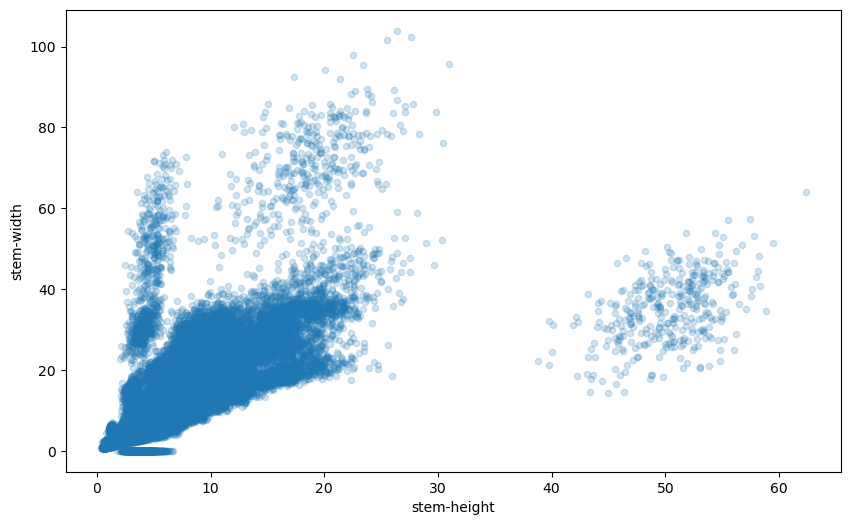

In [20]:
df.plot.scatter('cap-diameter','stem-width', figsize=(10,6), alpha=0.2,s=20)
plt.xlabel('stem-height')
plt.ylabel('stem-width')
plt.show()

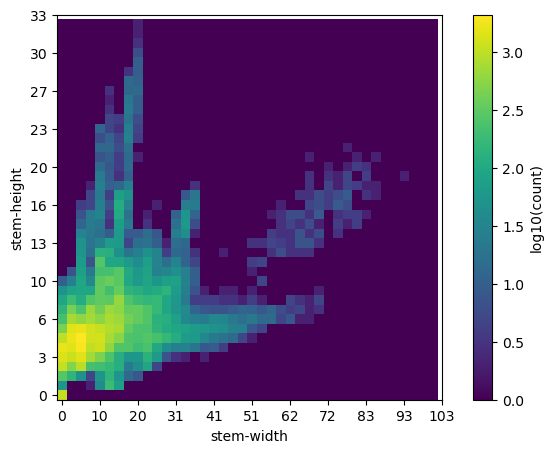

In [58]:
nbins = 40

heatmap, xedges, yedges = np.histogram2d(df['stem-width'], df['stem-height'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap[heatmap == 0] = 0.1 # we will use log and log(0) is undefined
plt.figure(figsize=(8,5))

plt.imshow(np.log10(heatmap).T, origin='lower',vmin=0) # use log count
plt.xlabel('stem-width')
plt.ylabel('stem-height')
plt.xticks(np.arange(nbins+1)[::4],xedges[::4].astype(int))
plt.yticks(np.arange(nbins+1)[::4],yedges[::4].astype(int))
plt.colorbar(label='log10(count)')
plt.show()

# splitting

In [60]:
# split the dataset into Other set and Test set
def basic_split(X, y, other_size, test_size, random_state):
    # test the inputs
    if (other_size+test_size != 1):
        print("The split size does not add up to 1")
        raise ValueError
    if not isinstance(random_state, int):
        print("The random state entered in not an integer")
        raise ValueError
    if X.shape[0] != y.shape[0]:
        print("The number of rows in X is not the same as the length of y")
        raise ValueError
    if len(X.shape) != 2:
        print("Input X is not a 2-D pandas dataframe")
        raise ValueError
    if len(y.shape) != 1:
        print("Input y is not a 1-D pandas series")
        raise ValueError

    # split the dataset into other and test
    X_other, X_test, y_other, y_test = train_test_split(X, y,
                                                          train_size = other_size, 
                                                          random_state = random_state)
  
    return X_other, y_other, X_test, y_test

In [63]:
# split the dataset
X_other, y_other, X_test, y_test = basic_split(X, y, other_size = 0.85, test_size = 0.15, random_state=42)
print('The shape of each train, val, and test set are the following:')
print('X_other: {a}, X_test: {b}'.format(a=X_other.shape, b=X_test.shape))
print('y_other: {a}, y_test: {b}'.format(a=y_other.shape, b=y_test.shape))

The shape of each train, val, and test set are the following:
X_other: (51908, 20), X_test: (9161, 20)
y_other: (51908,), y_test: (9161,)


# preprocessing

In [103]:
binary_feature = ['does-bruise-or-bleed', 'has-ring']
onehot_features = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color','stem-root', 
                'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']
std_features = ['cap-diameter','stem-height','stem-width']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_features),
        ('std', StandardScaler(), std_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here
clf.set_output(transform='pandas')

X_other_prep = clf.fit_transform(X_other) # save for later use
X_test_prep = clf.transform(X_test)

print('Shape of X_train before transformation:', X_other.shape)
print('Shape of X_train after transformation:', X_other_prep.shape)
print('Note: the X_train here refers to X_other in code')
X_other_prep.head()


Shape of X_train before transformation: (51908, 20)
Shape of X_train after transformation: (51908, 124)
Note: the X_train here refers to X_other in code


,onehot__cap-shape_b,onehot__cap-shape_c,onehot__cap-shape_f,onehot__cap-shape_o,onehot__cap-shape_p,onehot__cap-shape_s,onehot__cap-shape_x,onehot__cap-surface_d,onehot__cap-surface_e,onehot__cap-surface_g,...,onehot__habitat_p,onehot__habitat_u,onehot__habitat_w,onehot__season_a,onehot__season_s,onehot__season_u,onehot__season_w,std__cap-diameter,std__stem-height,std__stem-width
10927,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.915889,-0.427713,-1.016088
9195,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.634571,-0.651436,-0.890835
53830,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.713573,-0.203990,2.509889
54365,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.295841,-0.308394,0.272230
13868,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.199815,1.970598,-0.382864


In [65]:
# Check the missing values of data
# columns that have missing value
perc_missing_per_ftr = X_other_prep.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
Series([], dtype: float64)


Among 20 features, there are 9 features that comtains missing value. 

# Perform KFold

In [68]:
def perform_kfold(X_other, y_other, nfolds, random_state, clf: Pipeline):
    ''' 
    X_other: pandas dataframe
    y_other: pandas dataframe
    nfolds: the folds number we want to perform in kfold
    random_state: the random state
    clf: the preprocessor pipeline for scaling and standardizing
    '''
    res_score_metrics = dict()
    kf = KFold(n_splits=nfolds,shuffle=True,random_state=random_state)
    for train_index, val_index in kf.split(X_other,y_other):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]

        # transform the 
        X_train_prep = clf.fit_transform(X_train)
        X_val_prep = clf.transform(X_val)

        # later the different models will be used here to calculate the accuracy score, and then compute the average of this score
    return res_score_metrics

# feature selection

In [70]:
np.random.seed(10)

f_test, p_values = f_classif(X_other_prep, y_other)
#print('f score',f_test)
#print('p values',p_values)
mi = mutual_info_classif(X_other_prep, y_other)
#print('mi',mi)

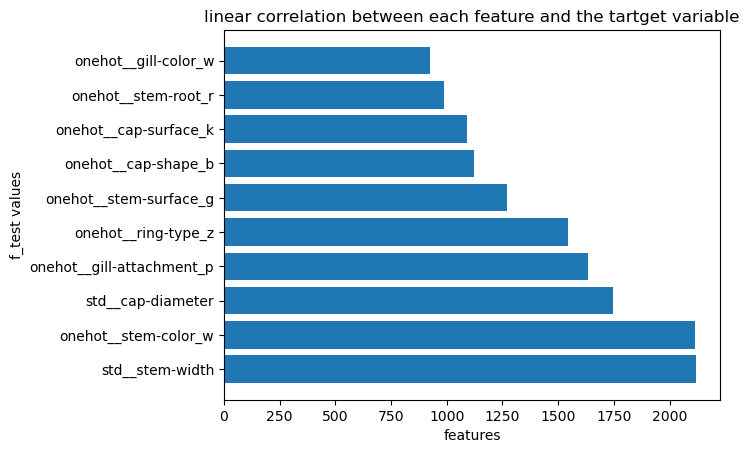

In [71]:
# perform the f test to test the linear correlation between features and target var
f_test, p_values = f_classif(X_other_prep, y_other)
df_ftest = pd.DataFrame(dict(
    features = X_other_prep.columns,
    f_test = f_test,
    p_values = p_values
)).sort_values('f_test', ascending=False)

# plot the bar plot
plt.barh(df_ftest.features[:10], df_ftest.f_test[:10])
plt.ylabel('f_test values')
plt.xlabel('features')
plt.title('linear correlation between each feature and the tartget variable')
plt.show()